In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:

class Person():
	""" Person (parent?) class -- will define how the person takes in a points signal and puts out an energy signal 
	baseline_energy = a list or dataframe of values. This is data from SinBerBEST 
	points_multiplier = an int which describes how sensitive each person is to points 

	"""

	def __init__(self, baseline_energy_df, points_multiplier = 1):
		self.baseline_energy_df = baseline_energy_df
		self.baseline_energy = np.array(self.baseline_energy_df["net_energy_use"])
		self.points_multiplier = points_multiplier
		
		baseline_min = self.baseline_energy.min()
		baseline_max = self.baseline_energy.max()
		baseline_range = baseline_max - baseline_min
		
		self.min_demand = np.maximum(0, baseline_min + baseline_range * .05)
		self.max_demand = np.maximum(0, baseline_min + baseline_range * .95)


	def energy_output_simple_linear(self, points):
		"""Determines the energy output of the person, based on the formula:
		
		y[n] = -sum_{rolling window of 5} points + baseline_energy + noise

		inputs: points - list or dataframe of points values. Assumes that the 
		list will be in the same time increment that energy_output will be. 

		For now, that's in 1 hour increments

		"""
		points_df = pd.DataFrame(points)
		
		points_effect = (
			points_df
				.rolling(
						window = 5,
						min_periods = 1)
				.mean()
			)

		time = points_effect.shape[0]
		energy_output= []

		for t in range(time):
			temp_energy = self.baseline_energy[t] - points_effect.iloc[t]*self.points_multiplier + \
				np.random.normal(1)
			energy_output.append(temp_energy)
			
		return pd.DataFrame(energy_output)

	def pure_linear_signal(self, points, baseline_day=0):
		"""
		A linear person. The more points you give them, the less energy they will use
		(within some bounds) for each hour. No rolling effects or anything. The simplest
		signal. 
		"""

		# hack here to always grab the first day from the baseline_energy
		output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]

		points_effect = np.array(points * self.points_multiplier)
		output = output - points_effect

		# impose bounds/constraints
		output = np.maximum(output, self.min_demand)
		output = np.minimum(output, self.max_demand)
		return output



	def get_min_demand(self):
		return self.min_demand
		# return np.quantile(self.baseline_energy, .05)

	def get_max_demand(self):
		return self.max_demand
		# return np.quantile(self.baseline_energy, .95)

class FixedDemandPerson(Person):

	def __init__(self, baseline_energy_df, points_multiplier = 1):
		super().__init__(baseline_energy_df, points_multiplier)


	def demand_from_points(self, points, baseline_day=0):
		# hack here to always grab the first day from the baseline_energy
		output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]
		total_demand = np.sum(output)


		points_effect = np.array(points * self.points_multiplier)
		output = output - points_effect

		# scale to keep total_demand (almost) constant
		# almost bc imposing bounds afterwards
		output = output * (total_demand/np.sum(output))

		# impose bounds/constraints
		output = np.maximum(output, self.min_demand)
		output = np.minimum(output, self.max_demand)

		return output

	def adverserial_linear(self, points, baseline_day=0):
		# hack here to always grab the first day from the baseline_energy
		output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]
		total_demand = np.sum(output)


		points_effect = np.array(points * self.points_multiplier)
		output = output + points_effect

		# scale to keep total_demand (almost) constant
		# almost bc imposing bounds afterwards
		output = output * (total_demand/np.sum(output))

		# impose bounds/constraints
		output = np.maximum(output, self.min_demand)
		output = np.minimum(output, self.max_demand)

		return output

In [3]:
class CurtailAndShiftPerson(Person):
	def __init__(self, baseline_energy_df, points_multiplier = 1, shiftable_load_frac = .7, 
			curtailable_load_frac = .4, shiftByHours = 3, maxCurtailHours=5, response = None, **kwargs):
		super().__init__(baseline_energy_df, points_multiplier)
		self.shiftableLoadFraction = shiftable_load_frac
		self.shiftByHours = shiftByHours
		self.curtailableLoadFraction = curtailable_load_frac
		self.maxCurtailHours = maxCurtailHours #Person willing to curtail for no more than these hours

	def shiftedLoad(self, points, baseline_day=0, day_of_week=None):
		output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]
		points = np.array(points) * self.points_multiplier
		shiftableLoad = self.shiftableLoadFraction*output
		shiftByHours = self.shiftByHours
		
		# 10 hour day. Rearrange the sum of shiftableLoad into these hours by treating points as the 'price' at that hour
		# Load can be shifted by a max of shiftByHours (default = 3 hours)
		# For each hour, calculate the optimal hour to shift load to within +- 3 hours
		shiftedLoad = np.zeros(10)
		for hour in range(10):
			candidatePrices = points[max(hour-shiftByHours,0): min(hour+shiftByHours,9)+1]
			shiftToHour = max(hour-shiftByHours,0) + np.argmin(candidatePrices)
			shiftedLoad[shiftToHour] += shiftableLoad[hour]		
		return shiftedLoad

	def curtailedLoad(self, points, baseline_day=0, day_of_week=None):
		output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]
		points = np.array(points) * self.points_multiplier
		curtailableLoad = self.curtailableLoadFraction*output
		maxPriceHours = np.argsort(points)[0:self.maxCurtailHours]
		for hour in maxPriceHours:
			curtailableLoad[hour] = 0
		return curtailableLoad

	def get_response(self, points, day_of_week=None):
		baseline_day = 0
		output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]
		energy_resp = output*(1 - self.curtailableLoadFraction - self.shiftableLoadFraction) + self.curtailedLoad(points) + self.shiftedLoad(points)
		
			
		self.min_demand = np.maximum(0, min(energy_resp))
		self.max_demand = np.maximum(0, max(energy_resp))

		return energy_resp





In [4]:
a = {"net_energy_use":[15.09,  35.6, 123.5,  148.7,  158.49, 149.13, 159.32, 157.62, 158.8,  156.49]}

In [5]:
bob = CurtailAndShiftPerson(baseline_energy_df=a)

In [6]:
output_data = []

# square_waves = np.array([[0,0,0,0,0,0,0,0,1,0],
#                         [0,0,0,0,0,0,0,0,1,0],
#                         [1,0,0,0,0,0,0,0,0,0],
#                         [1,0,0,0,0,0,0,0,0,0],
#                         [0,1,0,0,0,0,0,0,0,0],
#                         [0,1,0,0,0,0,0,0,0,0],
#                         [0,0,1,0,0,0,0,0,0,1],
#                         [0,0,1,0,0,0,0,0,0,1],
#                         [0,0,0,1,0,0,0,0,0,0],
#                         [0,0,0,1,0,0,0,0,0,0]])
train_size = 1000
square_waves = np.random.uniform(size=[train_size, 10])
square_waves /= np.sum(square_waves, axis=-1, keepdims=True)
val_size = 256
validation_waves = np.random.uniform(size=[256, 10])
validation_waves = validation_waves  / np.sum(validation_waves, axis=-1, keepdims=True)
validation_data = []

for day in range(square_waves.shape[0]):
    output_data.append(bob.get_response(square_waves[day]))
for day in range(validation_waves.shape[0]):
    validation_data.append(bob.get_response(validation_waves[day]))
    
output_data=np.array(output_data)
validation_data = np.array(validation_data)

In [7]:
import pandas as pd
pd.DataFrame(output_data).describe()

,0,1,2,3,4,5,6,7,8,9
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,39.901462,57.528721,80.574891,101.992539,107.927994,131.965088,144.061344,139.083939,99.867909,107.167921
std,78.789229,112.501390,134.160898,167.689655,189.636035,219.111328,230.913096,217.239594,163.842835,150.037648
min,-1.509000,-3.560000,-12.350000,-14.870000,-15.849000,-14.913000,-15.932000,-15.762000,-15.880000,-15.649000
25%,4.527000,7.003000,-1.787000,20.613000,9.071000,44.739000,47.796000,47.286000,-15.880000,46.947000
50%,4.527000,10.680000,37.050000,44.610000,47.547000,44.739000,47.796000,47.286000,47.640000,46.947000
75%,9.054000,10.680000,37.050000,44.610000,47.547000,96.030000,93.611000,93.781000,47.640000,93.894000
max,224.514000,333.406000,429.007000,538.011000,636.803000,723.979000,746.053000,642.133000,531.072000,426.912000


In [8]:
square_waves[:, 1]
validation_waves[1]

array([0.01595884, 0.08764624, 0.04833132, 0.2171418 , 0.13811447,
       0.20399528, 0.00293252, 0.10777224, 0.01438616, 0.16372112])

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.0001, 1))
train_data_normalized = output_data #scaler.fit_transform(output_data.reshape(-1, 1))
val_data_normalized = validation_data#scaler.transform(validation_data.reshape(-1, 1))

In [10]:
output_data_normalized = train_data_normalized.reshape(-1,10)
val_data_normalized = val_data_normalized.reshape([-1, 10])

In [11]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)
        self.hidden3 = torch.nn.Linear(n_hidden, n_hidden)  
        self.predict = torch.nn.Linear(n_hidden, n_output)  

    def forward(self, x):
        x = F.relu(self.hidden(x))      
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = self.predict(x)        
        x = x**2 # ensures costs will all be positive     
        return x

In [12]:
net = Net(n_feature=10, n_hidden=32, n_output=10)     # define the network
print(net)  # net architecture
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss() 

Net(
  (hidden): Linear(in_features=10, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=32, bias=True)
  (predict): Linear(in_features=32, out_features=10, bias=True)
)


In [13]:
from sklearn.linear_model import ElasticNet
l1_ratios = [0, 0.1, 0.5, 0.7, 0.95, 0.99, 1]
alphas = [10**i for i in range(-4, 2, 1)]
min_loss = None
best_l1_ratio=None
best_alpha=None
for l1_ratio in l1_ratios:
    for alpha in alphas:
        elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        elastic_net.fit(square_waves.reshape(-1, 1), output_data_normalized.reshape(-1, 1))
        val_out = elastic_net.predict(validation_waves.reshape(-1, 1))
        val_loss = loss_func(torch.tensor(val_data_normalized.reshape(-1, 1)), torch.tensor(val_out.reshape(-1, 1)))
        if min_loss is None or val_loss < min_loss:
            min_loss = val_loss
            best_l1_ratio = l1_ratio
            best_alpha = alpha
print("Min loss: {}, best l1 ratio: {}, best alpha: {}".format(min_loss, best_l1_ratio, best_alpha))

Min loss: 22361.48085003121, best l1 ratio: 0.99, best alpha: 0.01


/home/doseokt5/miniconda3/envs/neural_decoding/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114917089.67936327, tolerance: 30891.749441355714
  positive)
/home/doseokt5/miniconda3/envs/neural_decoding/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123296942.25859807, tolerance: 30891.749441355714
  positive)
/home/doseokt5/miniconda3/envs/neural_decoding/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144468577.04461348, tolerance: 30891.749441355714
  positive)
/home/doseokt5/miniconda3/envs/neural_decoding/lib/python3.7/site-packages/sklearn/linear_model/_coo

In [14]:
from copy import deepcopy
val_interval = 50
train_losses = []
val_losses = []
use_ols = False
best_model = None
best_val_loss = 1000000
# train the network
for t in range(10000):
    net.train()
    loss = 0
    prediction = net(torch.tensor(square_waves.reshape(-1, 10)).type(torch.FloatTensor))
    loss = loss_func(prediction, torch.tensor(output_data_normalized.reshape(-1, 10)).type(torch.FloatTensor))
    # for i in range(square_waves.shape[0]):
    #     if not use_ols:
    #         prediction = net(torch.tensor(square_waves[i].reshape(-1,1)).type(torch.FloatTensor))   
    #     else:
    #         prediction = torch.tensor(scaler.transform(86 + (5 * (square_waves[i].reshape(-1,1) - 5))))
    #     loss +=  loss_func(prediction, torch.tensor(output_data_normalized[i].reshape(-1,1)).type(torch.FloatTensor))     # must be (1. nn output, 2. target)
    #loss /= square_waves.shape[1]
    if not use_ols:
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
    #print("Training epoch {} loss: {}".format(t, loss))
    train_losses.append(loss.detach().numpy())
    
    optimizer.step()     
    if t % val_interval == 0:
        loss = 0
        net.eval()
        prediction = net(torch.tensor(validation_waves.reshape(-1, 10)).type(torch.FloatTensor))
        loss = loss_func(prediction, torch.tensor(val_data_normalized.reshape(-1, 10)).type(torch.FloatTensor))
        # for i in range(validation_waves.shape[0]):
            
        #     if not use_ols:
        #         prediction = net(torch.tensor(validation_waves[i].reshape(-1,1)).type(torch.FloatTensor))   
        #     else:
        #         prediction = torch.tensor(scaler.transform(86 + (5 * (validation_waves[i].reshape(-1,1) - 5))))
        #     loss +=  loss_func(prediction, torch.tensor(val_data_normalized[i].reshape(-1,1)).type(torch.FloatTensor))     # must be (1. nn output, 2. target)
        # loss /= validation_waves.shape[0]
        #print("Validation epoch {} loss: {}".format(t, loss))
        val_losses.append(loss.detach().numpy())
        if loss < best_val_loss:
            best_val_loss = loss
            
            best_model = deepcopy(net)

print("Best validation loss: ", min(val_losses))



Best validation loss:  8173.835


In [15]:
pd.DataFrame(prediction.detach().numpy()).describe()

,0,1,2,3,4,5,6,7,8,9
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,46.443523,60.907078,79.277534,97.660416,105.110161,128.461578,138.143631,134.029419,95.661644,103.766296
std,60.841457,98.636116,121.257469,158.653595,178.970795,211.784897,229.293396,212.017166,155.288849,141.277695
min,0.000008,0.000042,0.000474,0.000010,0.000014,0.000013,0.000002,0.000013,0.000005,0.000078
25%,4.102811,3.202381,13.991355,6.751064,7.770954,8.884500,8.738140,5.241854,8.363132,9.721380
50%,20.149786,15.272701,30.997064,27.159435,28.593267,31.693459,30.675326,26.715020,29.062377,38.010065
75%,61.900028,61.991158,67.089514,88.654753,87.059446,102.082151,118.073277,125.211918,79.300571,118.977854
max,311.235596,528.840515,642.409912,754.425659,806.571472,857.270752,865.836060,771.904053,672.742615,578.561035


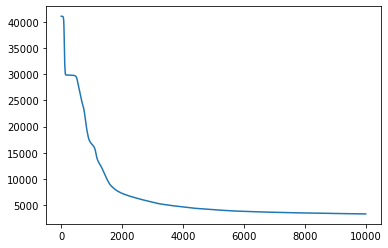

In [16]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

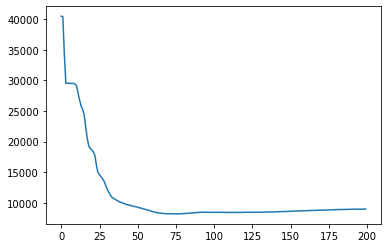

In [17]:
import matplotlib.pyplot as plt
plt.plot(val_losses)

In [18]:
torch.save(best_model.state_dict(), 'model_weights.pth')
#torch.save(scaler, "model_scaler.pth")

In [19]:
scaler

MinMaxScaler(feature_range=(0.0001, 1))

In [20]:
scaler.__dict__.keys()

dict_keys(['feature_range', 'copy', 'clip'])

In [21]:
scaler.scale_

AttributeError: 'MinMaxScaler' object has no attribute 'scale_'